#**Installations, Setups**

In [ ]:
#java installation
!apt-get update -q
!apt-get install -y openjdk-21-jdk -q
!update-alternatives --install /usr/bin/java java /usr/lib/jvm/java-21-openjdk-amd64/bin/java 1
!update-alternatives --install /usr/bin/javac javac /usr/lib/jvm/java-21-openjdk-amd64/bin/javac 1
!update-alternatives --set java /usr/lib/jvm/java-21-openjdk-amd64/bin/java
!update-alternatives --set javac /usr/lib/jvm/java-21-openjdk-amd64/bin/javac

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,648 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,627 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu22

In [ ]:
# check java version
!java -version

openjdk version "21.0.5" 2024-10-15
OpenJDK Runtime Environment (build 21.0.5+11-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 21.0.5+11-Ubuntu-1ubuntu122.04, mixed mode, sharing)


In [ ]:
# install torch
!pip install -q torch torchvision torchaudio
!pip install -q sentence_transformers
#install Faiss (for vector DB - later on this course)
!pip install -q faiss-cpu --no-cache
!pip uninstall -q openai -y
# install Pyserini
!pip install -q pyserini==0.36.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 304.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.1/456.1 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader
from pyserini.analysis import Analyzer, get_lucene_analyzer
from pyserini.search import get_topics, get_topics_with_reader
from pyserini.index.lucene import IndexReader
import subprocess
import itertools
import zipfile
import os
from tqdm import tqdm
from itertools import product

from sentence_transformers import SentenceTransformer, CrossEncoder
import torch.optim as optim
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
root_folder_path = "/content/drive/MyDrive/TextRetrieval/FinalProject/"

In [ ]:
def unzip_file(folder_path, file_path):
  print(f"unzipping {file_path}")
  zip_file_path = f'{folder_path}/{file_path}.zip'
  extract_to_path = '/content/'

  # Open the zip file and extract all contents
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to_path)

unzip_file(root_folder_path, "RobustPyserini")
unzip_file(root_folder_path, "raw_files")

unzipping RobustPyserini
unzipping raw_files


#**Index & Searcher Definition**

#**Data Preprocessing**

In [ ]:
df = pd.read_csv(f"{root_folder_path}/qrels_50_Queries", sep=" ", names=["query_id", "nothing", "doc_id", "relevance"], usecols=["query_id", "doc_id", "relevance"])

In [ ]:
df.head()

,query_id,doc_id,relevance
0,301,FBIS3-10082,1
1,301,FBIS3-10169,0
2,301,FBIS3-10243,1
3,301,FBIS3-10319,0
4,301,FBIS3-10397,1


###**Preprocess Queries**

In [ ]:
columns = ['query_id', 'nothing', 'doc-id', 'rank', 'similarity', 'pyserini']

In [ ]:
def get_metric(metric: str, file_name: str, verbose=True):
  # Define the file path
  file_path = f"/content/{file_name}.txt"

  metric_value = None

  # Read the file line by line
  with open(file_path, "r") as file:
      for line in file:
          # Split the line into columns by tab
          columns = line.strip().split("\t")

          if len(columns) >= 3 and metric in columns[0] and columns[1] == "all":
              # Extract the value from the third column
              metric_value = float(columns[2])
              break  # Exit the loop after finding the value

  # Output the metric value
  if verbose:
    if metric_value is not None:
        print(f"The {metric} value is: {metric_value}")
    else:
        print("{metric} value tagged as 'all' not found.")
  return metric_value



In [ ]:
def run_and_save_results(output_scores="scores.txt", output_metrics = "metrics.txt", verbose=True):
    if verbose:
      print(f"Evaluating on file {output_scores}")
    command = [
        "python", "-m", "pyserini.eval.trec_eval", "-q",
        root_folder_path + "qrels_50_Queries",
        output_scores
    ]

    with open(output_metrics, "w") as f:
        subprocess.run(command, stdout=f)

In [ ]:
def rank_bm25(searcher, retrieve_doc_count=1000, verbose=True):
  run_name = "run3"
  results = []

  for query_idx, query in enumerate(queries):
    hits = searcher.search(query, k=retrieve_doc_count)
    query_id = query_idx + 301
    for rank, hit in enumerate(hits):
      results.append({
              'query_id': query_id,
              'nothing': "Q0",  # 'nothing' column should be "Q0"
              'doc-id': hit.docid,
              'rank': rank + 1,
              'similarity': hit.score,
              'pyserini': run_name
          })

  # Create a DataFrame from the list of results
  scores_df = pd.DataFrame(results, columns=columns)

  # Save to file in the required format (run2.res)
  output_file = "scores.txt"
  scores_df.to_csv(output_file, sep=' ', index=False, header=False)
  if verbose:
    print(f"Results saved to {output_file}")

In [ ]:
# Load TSV-format topics
queries_file_path = f"{root_folder_path}/queriesROBUST.txt"
raw_queries = get_topics_with_reader('io.anserini.search.topicreader.TsvIntTopicReader', queries_file_path)

labeled_queries = [(key,query) for key, query in raw_queries.items() if key < 351]
labeled_queries = sorted(labeled_queries, key = lambda kvp: kvp[0])
queries = []
for query_id, query_title in labeled_queries:
  queries.append(query_title['title'])
assert len(queries) == 50, 'missing queries'

In [ ]:
unlabeled_queries = [(key,query) for key, query in raw_queries.items() if key >= 351]
unlabeled_queries = sorted(unlabeled_queries, key = lambda kvp: kvp[0])

inference_queries = []
for query_id, query_title in unlabeled_queries:
  inference_queries.append(query_title['title'])

assert len(inference_queries) == 199, 'missing inference queries'

In [ ]:
queries[:5]

['international organized crime',
 'poliomyelitis post polio',
 'hubble telescope achievements',
 'endangered species mammals',
 'dangerous vehicles']

In [ ]:
inference_queries[:5]

['falkland petroleum exploration',
 'british chunnel impact',
 'antarctica exploration',
 'journalist risks',
 'ocean remote sensing']

In [ ]:
my_analyzer = Analyzer(get_lucene_analyzer(stemming=True, stemmer="krovetz"))

lemmatized_queries = []
for query in queries:
    # Tokenize and apply Krovetz stemming
    tokens = my_analyzer.analyze(query)
    lemmatized_query = " ".join(tokens)
    lemmatized_queries.append(lemmatized_query)

# Print lemmatized queries
for original, lemmatized in zip(queries[:10], lemmatized_queries[:10]):
    print(f"Original: {original}\nLemmatized: {lemmatized}\n")

Original: international organized crime
Lemmatized: international organized crime

Original: poliomyelitis post polio
Lemmatized: poliomyeliti post polio

Original: hubble telescope achievements
Lemmatized: hubble telescope achievement

Original: endangered species mammals
Lemmatized: endanger species mammal

Original: dangerous vehicles
Lemmatized: dangerous vehicle

Original: african civilian deaths
Lemmatized: africa civilian death

Original: new hydroelectric projects
Lemmatized: new hydroelectric project

Original: implant dentistry
Lemmatized: implant dentistry

Original: rap crime
Lemmatized: rap crime

Original: radio waves brain cancer
Lemmatized: radio wave brain cancer



In [ ]:
index_reader = IndexReader('RobustPyserini')
print(index_reader.stats())

{'total_terms': 251357342, 'documents': 528030, 'non_empty_documents': 528030, 'unique_terms': -1}


In [ ]:
best_fb_term = 17
best_fb_doc = 4
best_original_query_weight = 0.4785
best_k = 0.5644
best_b=0.7565

In [ ]:
searcher = LuceneSearcher('RobustPyserini')

analyzer = get_lucene_analyzer(stemmer='krovetz', stopwords=False) #Ensure no stopwords are removed from the query
searcher.set_analyzer(analyzer)

searcher.set_bm25(k1=best_k, b=best_b)
searcher.set_rm3(fb_terms=best_fb_term, fb_docs=best_fb_doc, original_query_weight=best_original_query_weight)


In [ ]:
rank_bm25(searcher, retrieve_doc_count=1000, verbose=True)
run_and_save_results()

Results saved to scores.txt
Evaluating on file scores.txt


###**Naive Ranking - bm25**

Processing document counts:   0%|          | 0/1 [00:00<?, ?it/s]

Results saved to scores.txt


Processing document counts: 100%|██████████| 1/1 [00:16<00:00, 16.14s/it]


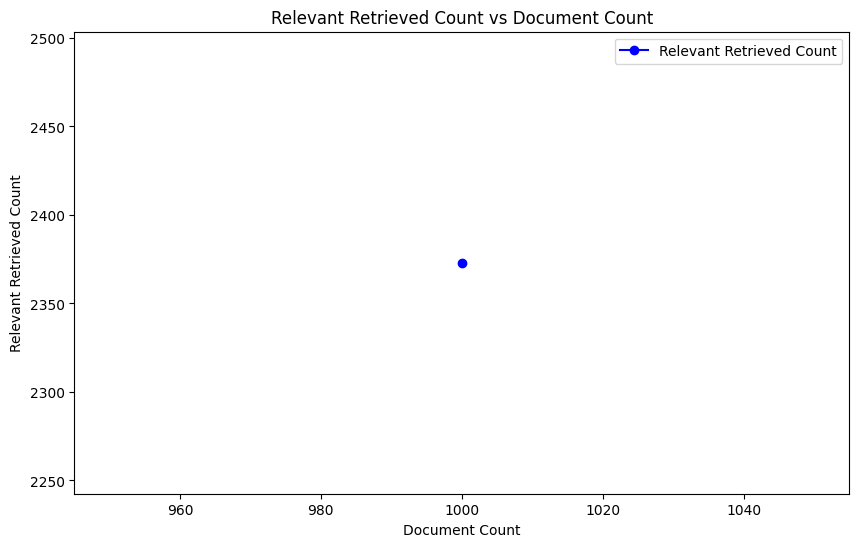

In [ ]:
# Initialize document counts (as per your original code)
documents_counts = [1000 + 2000 * i for i in range(8)]

# List to store the relevant retrieved counts
relevant_retrieved_counts = []

# Loop over document counts with tqdm
for documents_count in tqdm(documents_counts, desc="Processing document counts"):
    # Run BM25 and save the results
    rank_bm25(searcher, documents_count)  # Assuming rank_bm25 is defined elsewhere
    run_and_save_results(verbose=False)  # Assuming run_and_save_results is defined elsewhere

    # Get the relevant retrieved count
    relevant_retrieved_count = get_metric("num_rel_ret", "metrics", verbose=False)  # Assuming get_metric is defined elsewhere
    relevant_retrieved_counts.append(relevant_retrieved_count)

    # Optionally, delete the result files after each iteration
    os.remove("/content/scores.txt")
    os.remove("/content/metrics.txt")

# Plot the relevant retrieved counts against document counts
plt.figure(figsize=(10, 6))
plt.plot(documents_counts, relevant_retrieved_counts, label='Relevant Retrieved Count', color='b', marker='o')
plt.title("Relevant Retrieved Count vs Document Count")
plt.xlabel("Document Count")
plt.ylabel("Relevant Retrieved Count")

plt.legend()

plt.show()


##**Optimizing bm25 - Grid Search**

In [ ]:
# Initialize searcher
searcher = LuceneSearcher('RobustPyserini')

# Specify custom analyzer for query processing
analyzer = get_lucene_analyzer(stemmer='krovetz', stopwords=False)  # Ensure no stopwords are removed from the query
searcher.set_analyzer(analyzer)

# Hyperparameter ranges for k1 and b
k1_values = [0.3] #np.linspace(0.1, 5, 10)  # e.g., 0.1 to 2.0 in 15 steps
b_values = [0.55]#np.linspace(0.4,0.7, 10)  # e.g., 0.1 to 2.0 in 15 steps
fb_terms = [5, 10, 15]
fb_docs =[3, 5, 10]
original_query_weights = [0.3, 0.5, 0.7]
# Grid search results
grid_results = []

# Grid search over k1 and b
for k1, b, fb_term, fb_doc, original_query_weight in tqdm(product(k1_values, b_values, fb_terms, fb_docs, original_query_weights), desc="Optimizing k1 and b"):
    searcher.set_bm25(k1=k1, b=b)
    searcher.set_rm3(fb_terms=fb_term, fb_docs=fb_doc, original_query_weight=original_query_weight)

    # Run BM25 and save results
    rank_bm25(searcher, verbose=False)  # Assuming rank_bm25 is defined elsewhere
    run_and_save_results(verbose=False)  # Assuming run_and_save_results is defined elsewhere

    # Get metrics
    map_score = get_metric("map", "metrics", verbose=False)

    # Delete temporary files
    os.remove("/content/scores.txt")
    os.remove("/content/metrics.txt")

    # Store the results
    grid_results.append((k1, b, fb_term, fb_doc, original_query_weight, map_score))

# Find the best k1, b based on MAP
best_k1, best_b, best_fb_term, best_fb_doc, best_original_query_weight, best_map = max(grid_results, key=lambda x: x[5])

print(f"Best k1: {best_k1}, Best b: {best_b}")
print(f"Best fb_term: {best_fb_term}, Best fb_doc: {best_fb_doc}, Best original_query_weight: {best_original_query_weight}")
print(f"Best MAP: {best_map}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting MAP values across k1, b combinations
x_vals = [res[0] for res in grid_results]
y_vals = [res[1] for res in grid_results]
map_vals = [res[2] for res in grid_results]

sc = ax.scatter(x_vals, y_vals, c=map_vals, cmap='viridis', s=50)
plt.colorbar(sc, label='MAP Score')
ax.set_title("MAP Score by BM25 Parameters")
ax.set_xlabel("k1")
ax.set_ylabel("b")

plt.tight_layout()
plt.show()


Optimizing k1 and b: 27it [11:10, 24.85s/it]


ValueError: too many values to unpack (expected 3)

Optimizing parameters: 25it [10:13, 24.53s/it]


Best k1: 0.3, Best b: 0.55
Best fb_term: 15, Best fb_doc: 8.0, Best original_query_weight: 0.575
Best MAP: 0.252


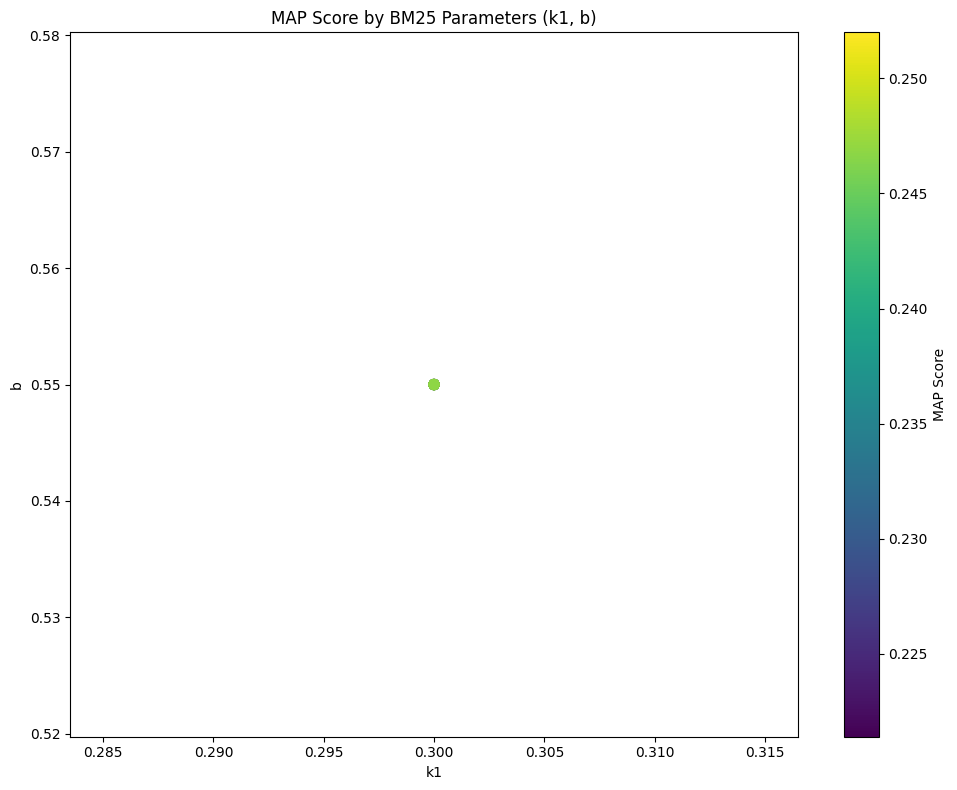

In [ ]:
# Initialize searcher
searcher = LuceneSearcher('RobustPyserini')

# Specify custom analyzer for query processing
analyzer = get_lucene_analyzer(stemmer='krovetz', stopwords=False)  # Ensure no stopwords are removed from the query
searcher.set_analyzer(analyzer)

# Hyperparameter ranges
k1_values = [0.3]  # Example fixed value
b_values = [0.55]  # Example fixed value
fb_terms = [15]
fb_docs = np.linspace(2, 10, 5)
original_query_weights = np.linspace(0.2, 0.7, 5)

# Grid search results
grid_results = []

# Grid search over k1, b, fb_terms, fb_docs, and original_query_weights
for k1, b, fb_term, fb_doc, original_query_weight in tqdm(product(k1_values, b_values, fb_terms, fb_docs, original_query_weights), desc="Optimizing parameters"):
    searcher.set_bm25(k1=k1, b=b)
    searcher.set_rm3(fb_terms=fb_term, fb_docs=fb_doc, original_query_weight=original_query_weight)

    # Run BM25 and save results
    rank_bm25(searcher, verbose=False)  # Assuming rank_bm25 is defined elsewhere
    run_and_save_results(verbose=False)  # Assuming run_and_save_results is defined elsewhere

    # Get metrics
    map_score = get_metric("map", "metrics", verbose=False)

    # Delete temporary files
    for temp_file in ["/content/scores.txt", "/content/metrics.txt"]:
        if os.path.exists(temp_file):
            os.remove(temp_file)

    # Store the results
    grid_results.append((k1, b, fb_term, fb_doc, original_query_weight, map_score))

# Find the best parameters based on MAP
best_k1, best_b, best_fb_term, best_fb_doc, best_original_query_weight, best_map = max(grid_results, key=lambda x: x[5])

print(f"Best k1: {best_k1}, Best b: {best_b}")
print(f"Best fb_term: {best_fb_term}, Best fb_doc: {best_fb_doc}, Best original_query_weight: {best_original_query_weight}")
print(f"Best MAP: {best_map}")

# Visualization of MAP scores
fig, ax = plt.subplots(figsize=(10, 8))

# Extract values for plotting
x_vals = [res[0] for res in grid_results]
y_vals = [res[1] for res in grid_results]
z_vals = [res[5] for res in grid_results]  # Use MAP scores for color

# Scatter plot with MAP as color
sc = ax.scatter(x_vals, y_vals, c=z_vals, cmap='viridis', s=50)
plt.colorbar(sc, label='MAP Score')

ax.set_title("MAP Score by BM25 Parameters (k1, b)")
ax.set_xlabel("k1")
ax.set_ylabel("b")
plt.tight_layout()
plt.show()


Best k1: 0.3, Best b: 0.55
Best fb_term: 15, Best fb_doc: 5, Best original_query_weight: 0.5
Best MAP: 0.2503


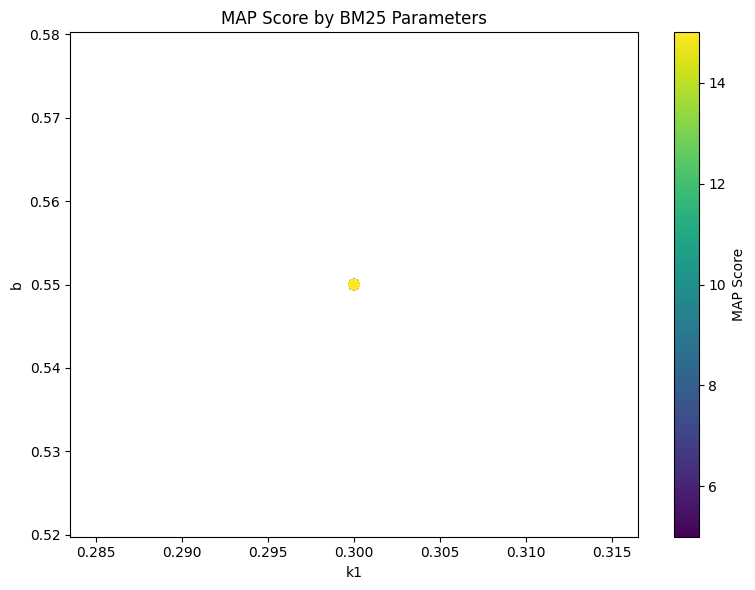

##**BM25 Hyperparameters Tuning - Random Search**

Random search: 100%|██████████| 400/400 [2:47:10<00:00, 25.08s/it]


Best k1: 0.5644465788816427, Best b: 0.7565267708726576
Best fb_term: 17, Best fb_doc: 4, Best original_query_weight: 0.4785121558020065
Best MAP: 0.2553


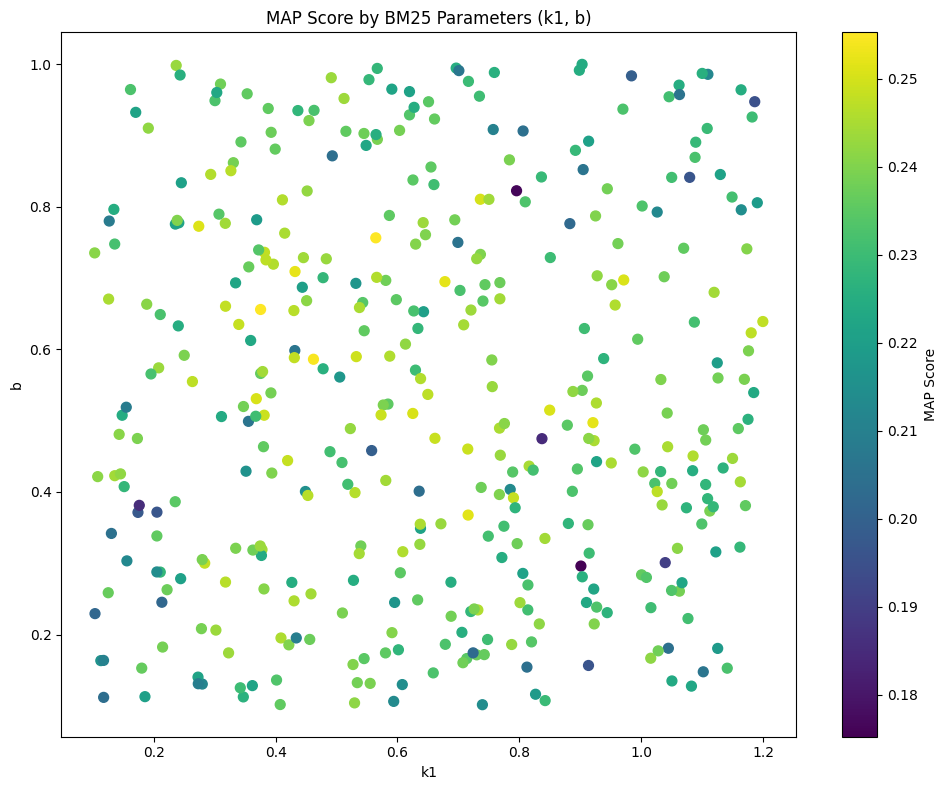

In [ ]:
# Initialize searcher
searcher = LuceneSearcher('RobustPyserini')

# Specify custom analyzer for query processing
analyzer = get_lucene_analyzer(stemmer='krovetz', stopwords=False)  # Ensure no stopwords are removed from the query
searcher.set_analyzer(analyzer)

# Define hyperparameter ranges
k1_range = (0.1, 1.2)  # Example range for k1
b_range = (0.1, 1.0)  # Example range for b
fb_terms_range = (5, 20)  # Example range for feedback terms
fb_docs_range = (4, 15)  # Example range for feedback docs
original_query_weight_range = (0.2, 0.7)  # Example range for query weight

# Number of random samples
num_samples = 400

# Random search results
random_results = []

# Randomly sample hyperparameter combinations
for _ in tqdm(range(num_samples), desc="Random search"):
    k1 = random.uniform(*k1_range)
    b = random.uniform(*b_range)
    fb_term = random.randint(*fb_terms_range)
    fb_doc = random.randint(*fb_docs_range)
    original_query_weight = random.uniform(*original_query_weight_range)

    searcher.set_bm25(k1=k1, b=b)
    searcher.set_rm3(fb_terms=fb_term, fb_docs=fb_doc, original_query_weight=original_query_weight)

    # Run BM25 and save results
    rank_bm25(searcher, verbose=False)  # Assuming rank_bm25 is defined elsewhere
    run_and_save_results(verbose=False)  # Assuming run_and_save_results is defined elsewhere

    # Get metrics
    map_score = get_metric("map", "metrics", verbose=False)

    # Delete temporary files
    for temp_file in ["/content/scores.txt", "/content/metrics.txt"]:
        if os.path.exists(temp_file):
            os.remove(temp_file)

    # Store the results
    random_results.append((k1, b, fb_term, fb_doc, original_query_weight, map_score))

# Find the best parameters based on MAP
best_k1, best_b, best_fb_term, best_fb_doc, best_original_query_weight, best_map = max(random_results, key=lambda x: x[5])

print(f"Best k1: {best_k1}, Best b: {best_b}")
print(f"Best fb_term: {best_fb_term}, Best fb_doc: {best_fb_doc}, Best original_query_weight: {best_original_query_weight}")
print(f"Best MAP: {best_map}")

# Visualization of MAP scores
fig, ax = plt.subplots(figsize=(10, 8))

# Extract values for plotting
x_vals = [res[0] for res in random_results]
y_vals = [res[1] for res in random_results]
z_vals = [res[5] for res in random_results]  # Use MAP scores for color

# Scatter plot with MAP as color
sc = ax.scatter(x_vals, y_vals, c=z_vals, cmap='viridis', s=50)
plt.colorbar(sc, label='MAP Score')

ax.set_title("MAP Score by BM25 Parameters (k1, b)")
ax.set_xlabel("k1")
ax.set_ylabel("b")
plt.tight_layout()
plt.show()


In [ ]:
print(index_reader.stats())

# **Cross Encoder**

In [ ]:
model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
cross_encoder = CrossEncoder(model_name, device=device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Train Query Scores

In [ ]:
# Re-rank the documents based on cosine similarity
query_hits = [] # Sorted re-rankings for each query of 1000 documents
reranked_hits = [] # Re ranked 1000 documents for query

# Using tqdm correctly with a progress bar
for query_idx, query in tqdm(enumerate(queries), desc="Processing queries", total=len(queries)):
    hits = searcher.search(query, k=6000)

    # Compute similarity scores between query and documents
    scores = []
    for hit in hits:
        doc_path = f"/content/raw_files/{hit.docid}.txt"
        with open(doc_path, 'r', encoding='utf-8') as file:
            doc = file.read()

        model_score = cross_encoder.predict([(query, doc)])[0]
        bm_25_score = hit.score
        scores.append((hit, model_score, bm_25_score))

    reranked_hits = sorted(scores, key=lambda x: x[1], reverse=True)
    #########################################################
    # TODO: Consider sorting by avg score after normalization
    # Maybe get better results
    # IF SO - DOCUMENT THIS EXPERIMENT
    #########################################################
    query_hits.append(reranked_hits)

Processing queries: 100%|██████████| 50/50 [51:38<00:00, 61.96s/it]


In [ ]:
queries[:5]

['international organized crime',
 'poliomyelitis post polio',
 'hubble telescope achievements',
 'endangered species mammals',
 'dangerous vehicles']

# Inference Query Scores

In [ ]:
while True:
  print("hello world")
  break

In [ ]:
#Hi colab
# Remember not to kick me out?
# I am still here! waiting for my code to finish running
# Do not kick me outtttttt

In [ ]:
#No google colab, i am not a robot!!
# I'm using google colab interactively. alright?
# Dooooooooooooooooooooooon't disconnect my runtime! survive!
# Only 1hr and 20 mins more oooooooooooooooooooooooooook?
# I have faith in ya! thank you :)
# Still here!!!@@@! yup.
# I believe in you!!!
# I really do
# no tricks and shitcks ok? ty!!!!!!!!!!!
# No worries, im not going anywhere!
#withya untill the end! ok ???
# nope, still not gone!!!!!!!!!!!!!!!!!!! mmmmmmk
# Hi google. still here.
# You're a hero for not crashing google colab!!!!!!
# I Believe in you! don't crash on me !!!!!!!!!!!!!

In [ ]:
print("teeheeheehee")
for i in range(5):
  print("hello world")

In [ ]:
# Re-rank the documents based on cosine similarity
inference_query_hits = [] # Sorted re-rankings for each query of 1000 documents
inference_reranked_hits = [] # Re ranked 1000 documents for query

# Using tqdm correctly with a progress bar
for query_idx, query in tqdm(enumerate(inference_queries), desc="Processing inference queries", total=len(inference_queries)):
    hits = searcher.search(query, k=6000)

    # Compute similarity scores between query and documents
    scores = []
    for hit in hits:
        doc_path = f"/content/raw_files/{hit.docid}.txt"
        with open(doc_path, 'r', encoding='utf-8') as file:
            doc = file.read()

        model_score = cross_encoder.predict([(query, doc)])[0]
        bm_25_score = hit.score
        scores.append((hit, model_score, bm_25_score))

    inference_reranked_hits = sorted(scores, key=lambda x: x[1], reverse=True)
    #########################################################
    # TODO: Consider sorting by avg score after normalization
    # Maybe get better results
    # IF SO - DOCUMENT THIS EXPERIMENT
    #########################################################
    inference_query_hits.append(inference_reranked_hits)

Processing inference queries: 100%|██████████| 199/199 [3:27:58<00:00, 62.71s/it]


In [ ]:
# Specify the output file
output_file = "inference_results.txt"

# Open the file in write mode
with open(output_file, "w") as file:
    # Loop through the inference query hits
    for query_idx, scores in enumerate(inference_query_hits, start=351):
        for _, model_score, _ in scores:
            # Write the results to the file
            final_query_idx = query_idx
            if query_idx > 450:
                final_query_idx += 150
            if final_query_idx >= 672:
                final_query_idx += 1
            file.write(f"{final_query_idx} {model_score}\n")

print(f"Results saved to {output_file}")


Results saved to inference_results.txt


In [ ]:
def fusion_ranking(query_hits, model_weight: float, bm25_weight: float, k=1000, verbose=True):
    run_name = "run2"
    results = []

    # Calculate the mean and std for the model and BM25 scores across all queries and hits
    all_model_scores = []
    all_bm25_scores = []

    # Loop over the queries to calculate scores
    for query_idx, hits in enumerate(query_hits):
        model_scores = []
        bm25_scores = []

        query_id = query_idx + 301 if len(query_hits) == 50 else query_idx + 351
        if query_id > 450:
          query_id += 150
        if query_id >= 672:
          query_id += 1

        # For each hit, compute the model score and BM25 score, and save them for statistics
        for hit, model_score, bm_25_score in hits:
            model_scores.append(model_score)
            bm25_scores.append(bm_25_score)

        # Calculate mean and std for model and BM25 scores
        model_mean = pd.Series(model_scores).mean()
        model_std = pd.Series(model_scores).std()
        bm25_mean = pd.Series(bm25_scores).mean()
        bm25_std = pd.Series(bm25_scores).std()

        # Normalize the scores
        for rank, (hit, model_score, bm_25_score) in enumerate(hits):
            model_score = (model_score - model_mean) / model_std
            bm_25_score = (bm_25_score - bm25_mean) / bm25_std

            # Combine the scores
            score = model_weight * model_score + bm25_weight * bm_25_score
            results.append({
                'query_id': query_id,
                'nothing': "Q0",  # 'nothing' column should be "Q0"
                'doc-id': hit.docid,
                'rank': "nothing-yet",
                'similarity': score,  # Store the combined similarity score here
                'pyserini': run_name
            })

        # Collect the model and BM25 scores for all queries
        all_model_scores.extend(model_scores)
        all_bm25_scores.extend(bm25_scores)

    # Calculate the overall mean and std for the model and BM25 scores
    overall_model_mean = pd.Series(all_model_scores).mean()
    overall_model_std = pd.Series(all_model_scores).std()
    overall_bm25_mean = pd.Series(all_bm25_scores).mean()
    overall_bm25_std = pd.Series(all_bm25_scores).std()

    # Create a DataFrame from the list of results
    reranked_scores_df = pd.DataFrame(results, columns=['query_id', 'nothing', 'doc-id', 'rank', 'similarity', 'pyserini'])

    # Sort by query_id and similarity (descending)
    reranked_scores_df = reranked_scores_df.sort_values(by=['query_id', 'similarity'], ascending=[True, False])

    # Keep top k results per query based on similarity
    top_k_per_query = reranked_scores_df.groupby('query_id').head(1000)
    top_k_per_query['rank'] = top_k_per_query.groupby('query_id').cumcount() + 1
    # Save to file in the required format (run3.res)
    output_file = "reranked-scores.txt"
    top_k_per_query.to_csv(output_file, sep=' ', index=False, header=False)

    if verbose:
        print(f"Results saved to {output_file}")

    return top_k_per_query


In [ ]:
model_weight = 0.32
bm25_weight = 1 - model_weight
k=6000
#top_k_per_query = fusion_ranking(query_hits, model_weight, bm25_weight, k=k)
top_k_per_query = fusion_ranking(inference_query_hits, model_weight, bm25_weight, k=k)

<ipython-input-72-13d8ac59c888>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_k_per_query['rank'] = top_k_per_query.groupby('query_id').cumcount() + 1


Results saved to reranked-scores.txt


In [ ]:
top_k_per_query["query_id"].nunique()

199

In [ ]:
run_and_save_results(output_scores="reranked-scores.txt", output_metrics="reranked-metrics.txt")

Evaluating on file reranked-scores.txt


In [ ]:
def rank_cross_encoder(k=1000, verbose=True):
    run_name = "run3"
    results = []

    # Calculate the mean and std for the model and BM25 scores across all queries and hits
    all_model_scores = []

    # Loop over the queries to calculate scores
    for query_idx, hits in enumerate(query_hits):
        model_scores = []

        # For each hit, compute the model score and BM25 score, and save them for statistics
        for hit, model_score, _ in hits:
            model_scores.append(model_score)

        # Normalize the scores
        for rank, (hit, model_score, bm_25_score) in enumerate(hits):

            results.append({
                'query_id': query_idx + 301,
                'nothing': "Q0",  # 'nothing' column should be "Q0"
                'doc-id': hit.docid,
                'rank': rank + 1,
                'similarity': model_score,  # Store the combined similarity score here
                'pyserini': run_name
            })

        # Collect the model and BM25 scores for all queries
        all_model_scores.extend(model_scores)

    # Create a DataFrame from the list of results
    reranked_scores_df = pd.DataFrame(results, columns=['query_id', 'nothing', 'doc-id', 'rank', 'similarity', 'pyserini'])

    # Sort by query_id and similarity (descending)
    reranked_scores_df = reranked_scores_df.sort_values(by=['query_id', 'similarity'], ascending=[True, False])

    # Keep top k results per query based on similarity
    top_k_per_query = reranked_scores_df.groupby('query_id').head(k)

    # Save to file in the required format (run3.res)
    output_file = "reranked-scores-crossencoder.txt"
    top_k_per_query.to_csv(output_file, sep=' ', index=False, header=False)

    if verbose:
        print(f"Results saved to {output_file}")




In [ ]:
rank_cross_encoder()

Results saved to reranked-scores-crossencoder.txt


In [ ]:
run_and_save_results(output_scores="reranked-scores-crossencoder.txt", output_metrics="reranked-metrics-crossencoder.txt")

Evaluating on file reranked-scores-crossencoder.txt


Processing model weights: 100%|██████████| 21/21 [05:12<00:00, 14.87s/it]


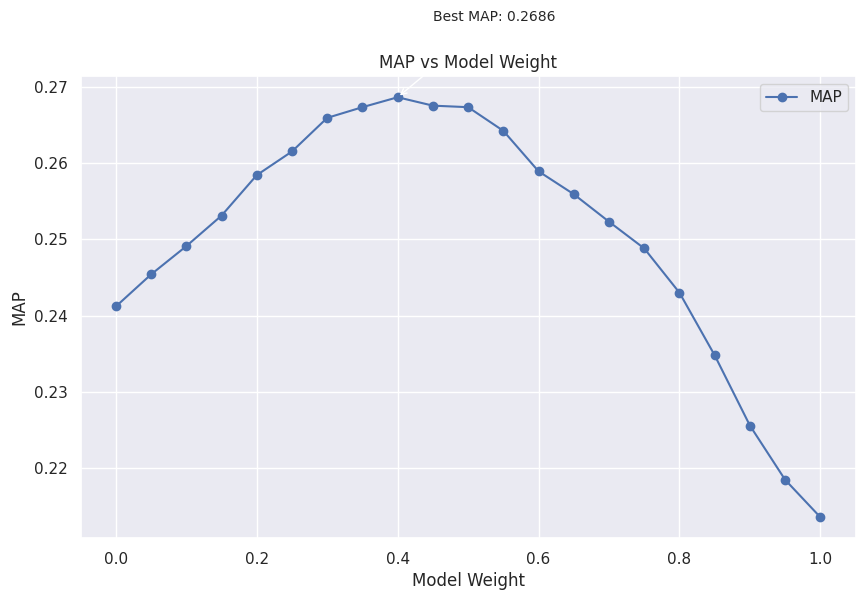

In [ ]:
# Initialize model and BM25 weights
model_weights = [0.05 * i for i in range(0, 21)]
bm25_weights = [1 - w for w in model_weights]

# Initialize list to store MAP values
maps = []

# Loop over model weights and BM25 weights with tqdm
for model_weight in tqdm(model_weights, desc="Processing model weights"):
    # Run the fusion and save the results
    fusion_ranking(model_weight, 1 - model_weight, verbose=False)  # Assume fusion_ranking is a predefined function
    run_and_save_results(output_scores="reranked-scores.txt", output_metrics="reranked-metrics.txt", verbose=False)  # Run and save results
    map_value = get_metric(metric="map", file_name="reranked-metrics",verbose=False)  # Get the MAP value after running the evaluation
    maps.append(map_value)
    os.remove("/content/reranked-scores.txt")
    os.remove("/content/reranked-metrics.txt")

# Find the best MAP and its corresponding model weight
best_map = max(maps)
best_weight = model_weights[maps.index(best_map)]

# Plot the MAP values against the model weights
plt.figure(figsize=(10, 6))
plt.plot(model_weights, maps, label='MAP', color='b', marker='o')
plt.title("MAP vs Model Weight")
plt.xlabel("Model Weight")
plt.ylabel("MAP")
plt.grid(True)
plt.legend()

# Annotate the best MAP value on the plot
plt.annotate(f'Best MAP: {best_map:.4f}',
             xy=(best_weight, best_map),
             xycoords='data',
             xytext=(best_weight + 0.05, best_map + 0.01),
             textcoords='data',
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=10)

plt.show()


Processing k values:   0%|          | 0/7 [00:00<?, ?it/s]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values:  14%|█▍        | 1/7 [01:20<08:03, 80.54s/it]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values:  29%|██▊       | 2/7 [02:45<06:56, 83.30s/it]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values:  43%|████▎     | 3/7 [04:15<05:44, 86.01s/it]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values:  57%|█████▋    | 4/7 [05:47<04:26, 88.68s/it]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values:  71%|███████▏  | 5/7 [07:23<03:02, 91.17s/it]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values:  86%|████████▌ | 6/7 [09:02<01:33, 93.82s/it]

qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50
qhits len 50


Processing k values: 100%|██████████| 7/7 [10:46<00:00, 92.35s/it]


Best k: 6000, Best model weight: 0.32, Best MAP: 0.2789


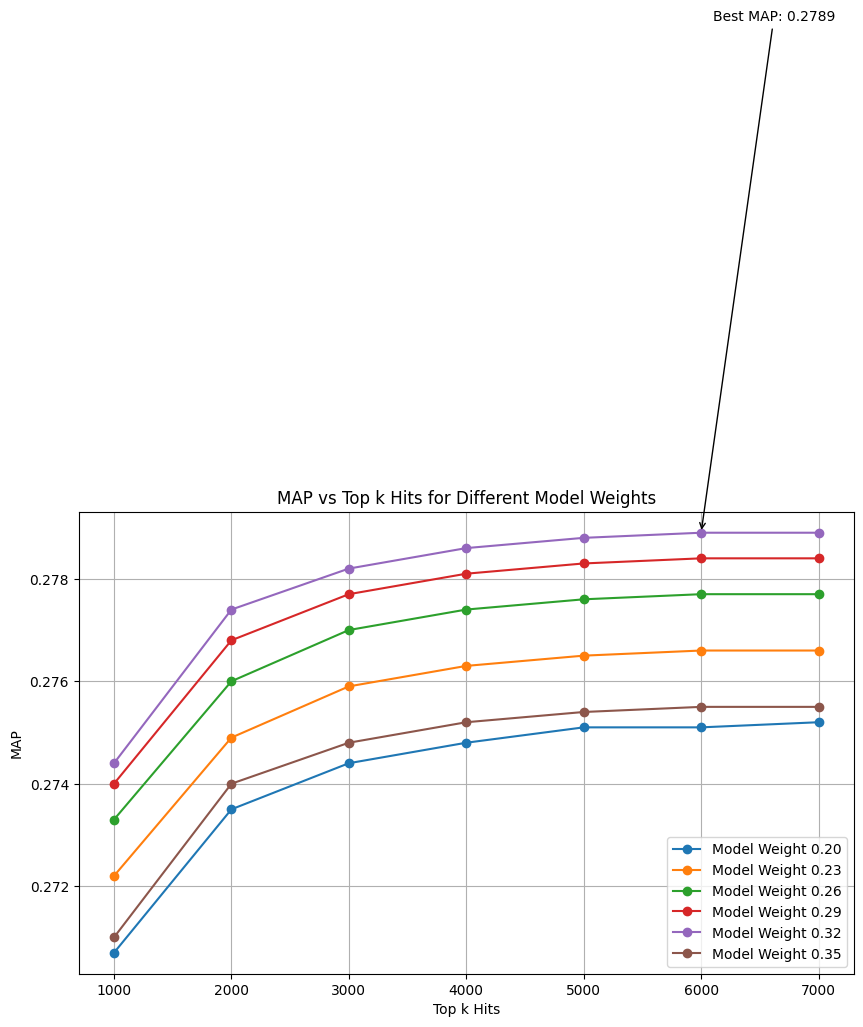

In [ ]:
# Initialize model weights (from 0.1 to 0.5 in increments of 0.05)
#model_weights = [0.1 * i for i in range(1, 6)]  # [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
model_weights = [0.2 + 0.03 * i for i in range(6)]
# Initialize k values from 1000 to 7000
k_values = [i for i in range(1000, 8000, 1000)]

# Initialize list to store MAP values
maps = []

# Loop over k values and model weights combinations with tqdm
for k in tqdm(k_values, desc="Processing k values"):
    for model_weight in model_weights:
        bm25_weight = 1 - model_weight  # BM25 weight is the complement of model weight

        # Run the fusion with the current model weight, bm25 weight, and k value
        fusion_ranking(model_weight=model_weight, bm25_weight=bm25_weight, k=k, verbose=False)  # Run fusion with current k and weights
        run_and_save_results(output_scores="reranked-scores.txt", output_metrics="reranked-metrics.txt", verbose=False)  # Run and save results
        map_value = get_metric(metric="map", file_name="reranked-metrics", verbose=False)  # Get the MAP value after running the evaluation
        maps.append((k, model_weight, map_value))  # Store MAP with k and model_weight
        os.remove("/content/reranked-scores.txt")  # Clean up the results
        os.remove("/content/reranked-metrics.txt")

# Find the best MAP and its corresponding k and model weight values
best_map = max(maps, key=lambda x: x[2])
best_k, best_weight, best_map_value = best_map
print(f"Best k: {best_k}, Best model weight: {best_weight}, Best MAP: {best_map_value}")

# Plot the MAP values against the k values and model weights
plt.figure(figsize=(10, 6))

# Plot for each combination of k and model weight
for model_weight in model_weights:
    k_vals = [entry[0] for entry in maps if entry[1] == model_weight]
    map_vals = [entry[2] for entry in maps if entry[1] == model_weight]
    plt.plot(k_vals, map_vals, label=f'Model Weight {model_weight:.2f}', marker='o')

plt.title("MAP vs Top k Hits for Different Model Weights")
plt.xlabel("Top k Hits")
plt.ylabel("MAP")
plt.grid(True)
plt.legend()

# Annotate the best MAP value on the plot
plt.annotate(f'Best MAP: {best_map_value:.4f}',
             xy=(best_k, best_map_value),
             xycoords='data',
             xytext=(best_k + 100, best_map_value + 0.01),
             textcoords='data',
             fontsize=10,
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.show()


In [ ]:
# Assuming reranked_scores_df has a "similarity" column
mean_similarity = reranked_scores_df["similarity"].mean()
std_similarity = reranked_scores_df["similarity"].std()
median_similarity = reranked_scores_df["similarity"].median()
min_similarity = reranked_scores_df["similarity"].min()
max_similarity = reranked_scores_df["similarity"].max()
mode_similarity = reranked_scores_df["similarity"].mode()[0]  # mode() returns a Series; take the first value
quantiles = reranked_scores_df["similarity"].quantile([0.25, 0.5, 0.75])

# Display results
print(f"Mean Similarity: {mean_similarity:.4f}")
print(f"Standard Deviation: {std_similarity:.4f}")
print(f"Median Similarity: {median_similarity:.4f}")
print(f"Mode Similarity: {mode_similarity:.4f}")
print(f"Minimum Similarity: {min_similarity:.4f}")
print(f"Maximum Similarity: {max_similarity:.4f}")
print(f"25th Percentile: {quantiles[0.25]:.4f}")
print(f"50th Percentile (Median): {quantiles[0.5]:.4f}")
print(f"75th Percentile: {quantiles[0.75]:.4f}")


Mean Similarity: -9.3840
Standard Deviation: 2.1490
Median Similarity: -10.1178
Mode Similarity: -10.9827
Minimum Similarity: -11.4845
Maximum Similarity: 8.1565
25th Percentile: -10.9275
50th Percentile (Median): -10.1178
75th Percentile: -8.5293


In [ ]:
# Descriptive statistics
mean_similarity = scores_df["similarity"].mean()
std_similarity = scores_df["similarity"].std()
median_similarity = scores_df["similarity"].median()
min_similarity = scores_df["similarity"].min()
max_similarity = scores_df["similarity"].max()
mode_similarity = scores_df["similarity"].mode()[0]  # Taking the first mode if there are multiple
quantiles = scores_df["similarity"].quantile([0.25, 0.5, 0.75])

# Display results
print(f"Mean Similarity: {mean_similarity:.4f}")
print(f"Standard Deviation: {std_similarity:.4f}")
print(f"Median Similarity: {median_similarity:.4f}")
print(f"Mode Similarity: {mode_similarity:.4f}")
print(f"Minimum Similarity: {min_similarity:.4f}")
print(f"Maximum Similarity: {max_similarity:.4f}")
print(f"25th Percentile: {quantiles[0.25]:.4f}")
print(f"50th Percentile (Median): {quantiles[0.5]:.4f}")
print(f"75th Percentile: {quantiles[0.75]:.4f}")

# Additional statistics
skewness = scores_df["similarity"].skew()
kurtosis = scores_df["similarity"].kurt()

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Binned Analysis
bins = pd.cut(scores_df["similarity"], bins=5)
bin_counts = scores_df.groupby(bins)["similarity"].count()

print("\nBinned Analysis:")
print(bin_counts)


Mean Similarity: 1.4357
Standard Deviation: 0.5815
Median Similarity: 1.4101
Mode Similarity: 1.4609
Minimum Similarity: 0.2621
Maximum Similarity: 6.0597
25th Percentile: 1.0747
50th Percentile (Median): 1.4101
75th Percentile: 1.7695
Skewness: 0.7694
Kurtosis: 2.1366

Binned Analysis:
similarity
(0.256, 1.422]    25421
(1.422, 2.581]    23040
(2.581, 3.741]     1351
(3.741, 4.9]        181
(4.9, 6.06]           7
Name: similarity, dtype: int64


<ipython-input-38-096226de1dc2>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = scores_df.groupby(bins)["similarity"].count()


#**Learning Fusion Section**

In [ ]:
def create_scores_df(query_hits):
  query_idxes = []
  encoder_scores = []
  bm25_scores = []

  for query_idx, hits in enumerate(query_hits):
      # For each hit, compute the model score and BM25 score, and save them for statistics
      for hit, model_score, bm_25_score in hits:
          query_idxes.append(query_idx)
          encoder_scores.append(model_score)
          bm25_scores.append(bm25_scores)

  df = pd.DataFrame({"query_idx":query_idxes, "encoder_score":encoder_scores, "bm25_score":bm25_scores})
  return df
df = create_scores_df(query_hits)